# Import the dataset from Kaggle

In [ ]:
! pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url='https://www.kaggle.com/datasets/ziya07/iot-secure-routing-dataset-for-intrusion-detection'
od.download(dataset_url)

# Install required packages

In [ ]:
!pip install xgboost

In [ ]:
!pip install imbalanced-learn

# Import necessary packages

In [ ]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,ConfusionMatrixDisplay
from xgboost import XGBClassifier
from xgboost import plot_importance
import matplotlib.pyplot as plt

# 1. Data preprocessing

In [ ]:
df = pd.read_csv('/content/iot-secure-routing-dataset-for-intrusion-detection/iot_routing_intrusion_dataset.csv')

In [ ]:
df.shape

(10000, 11)

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')

# Node Encoding


In [ ]:
srs_node = df['Source_Node'].unique()
dst_node= df['Destination_Node'].unique()
all_nodes = np.concatenate((srs_node, dst_node))
le = LabelEncoder()
all_nodes_Encoder = le.fit(all_nodes)
df['Source_Node'] = all_nodes_Encoder.transform(df['Source_Node'])
df['Destination_Node'] = all_nodes_Encoder.transform(df['Destination_Node'])

# Protocol, Encryption_Type, Hash_Match, Attack_Type encoding

In [ ]:
le_proto = LabelEncoder()
df['Protocol'] = le_proto.fit_transform(df['Protocol'])

le_enc = LabelEncoder()
df['Encryption_Type'] = le_enc.fit_transform(df['Encryption_Type'])

le_hash = LabelEncoder()
df['Hash_Match'] = le_hash.fit_transform(df['Hash_Match'])

le_attack = LabelEncoder()
df['Attack_Type'] = le_attack.fit_transform(df['Attack_Type'])

# 2. Binary classification only

In [ ]:
XB = df.drop(['Packet_ID', 'Timestamp', 'Is_Attack', 'Attack_Type'], axis=1)
yb = df['Is_Attack']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(XB, yb, stratify= yb, random_state=42)

features = ['Packet_Size', 'Packet_Delay(ms)']
Scaler = RobustScaler()
X_train_b[features] = Scaler.fit_transform(X_train_b[features])
X_test_b[features] = Scaler.fit_transform(X_test_b[features])

In [ ]:
XGb_model_b = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
XGb_model_b.fit(X_train_b, y_train_b)
XGb_pred_b = XGb_model_b.predict(X_test_b)

In [ ]:
print('XGBoost Model Performance on Test Set:')
print(f"Accuracy: {accuracy_score(y_test_b, XGb_pred_b):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_b, XGb_pred_b))

XGBoost Model Performance on Test Set:
Accuracy: 0.9640

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2133
           1       1.00      0.75      0.86       367

    accuracy                           0.96      2500
   macro avg       0.98      0.88      0.92      2500
weighted avg       0.97      0.96      0.96      2500



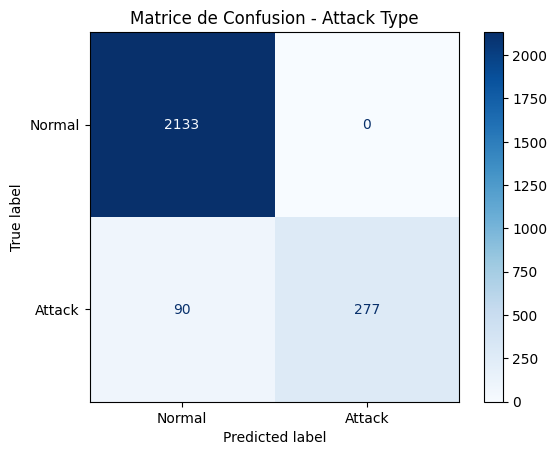

In [ ]:
class_names = ['Normal', 'Attack']
cm = confusion_matrix(y_test_b, XGb_pred_b)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion - Attack Type")
plt.show()

# 3.Multi class classification

# 3.1 Data splitting : 80% train, 20% test

In [ ]:
X = df.drop(['Packet_ID', 'Timestamp', 'Is_Attack', 'Attack_Type'], axis=1)
y = df['Attack_Type']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, random_state=42)

In [ ]:
features = ['Packet_Size', 'Packet_Delay(ms)']

Scaler = RobustScaler()
X_train[features] = Scaler.fit_transform(X_train[features])
X_test[features] = Scaler.fit_transform(X_test[features])

# 3.2 Apply Undersampling strategy only on train set

In [ ]:
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)

In [ ]:
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

In [ ]:
print(f"Avant équilibrage : {Counter(y_train)}")
print(f"Après équilibrage : {Counter(y_train_res)}")

Avant équilibrage : Counter({2: 6398, 3: 380, 1: 373, 0: 349})
Après équilibrage : Counter({0: 349, 1: 349, 2: 349, 3: 349})


# 3.3 Train/evaluate the model

In [ ]:
XGb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
XGb_model.fit(X_train_res, y_train_res)
XGb_pred = XGb_model.predict(X_test)

In [ ]:
print('XGBoost Model Performance on Test Set:')
print(f"Accuracy: {accuracy_score(y_test, XGb_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, XGb_pred))

XGBoost Model Performance on Test Set:
Accuracy: 0.7508

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.22      0.16       116
           1       0.20      0.30      0.24       125
           2       0.95      0.84      0.89      2133
           3       0.14      0.25      0.18       126

    accuracy                           0.75      2500
   macro avg       0.35      0.40      0.37      2500
weighted avg       0.83      0.75      0.79      2500



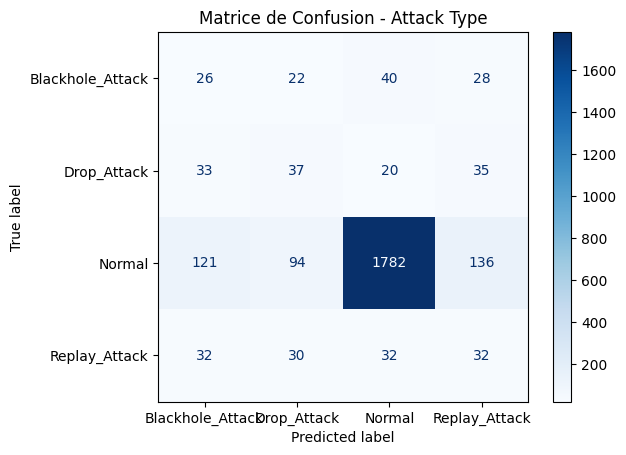

In [ ]:
class_names = le_attack.classes_
cm = confusion_matrix(y_test, XGb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion - Attack Type")
plt.show()

# 3.3 Plot the most important features that impact the decision of XGB

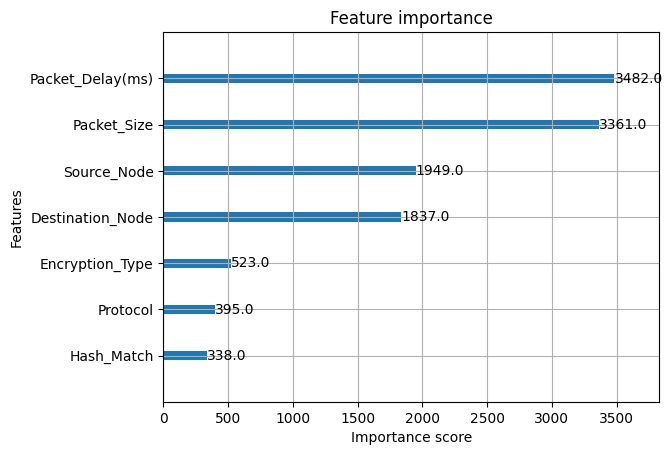

In [ ]:
plot_importance(XGb_model, max_num_features=10, importance_type='weight')  # ou 'gain'/'cover'
plt.show()

# 4.Multi class classification with windowing

In [ ]:
df['Rolling_Delay'] = df.groupby('Source_Node')['Packet_Delay(ms)'].transform(lambda x: x.rolling(window=10).mean())

In [ ]:
df['Size_Diff'] = df['Packet_Size'].diff()

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [ ]:
print(f"Avant équilibrage : {Counter(y_train)}")
print(f"Après équilibrage : {Counter(y_train_res)}")

Avant équilibrage : Counter({2: 6398, 3: 380, 1: 373, 0: 349})
Après équilibrage : Counter({2: 6398, 0: 6398, 3: 6398, 1: 6398})


In [ ]:
XGb_model_w = XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=12, random_state=42)
XGb_model_w.fit(X_train_res, y_train_res)
XGb_pred_w = XGb_model_w.predict(X_test)

In [ ]:
print('XGBoost Model Performance on Test Set:')
print(f"Accuracy: {accuracy_score(y_test, XGb_pred_w):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, XGb_pred_w))

XGBoost Model Performance on Test Set:
Accuracy: 0.8532

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.20      0.21       116
           1       0.30      0.31      0.31       125
           2       0.95      0.95      0.95      2133
           3       0.27      0.28      0.27       126

    accuracy                           0.85      2500
   macro avg       0.44      0.44      0.44      2500
weighted avg       0.85      0.85      0.85      2500

